In [1]:
import torch 
from torch.utils.data import random_split
import numpy as np
torch.manual_seed(42)
np.random.seed(42)

import sys
sys.path.append("../GCNet")
from GCNet_model import GCNet

import torch.nn as nn
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt




In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class ImageDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images = sorted(os.listdir(images_dir))
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.images_dir, self.images[idx]))
        #image = image.convert('RGB')


        # Split the image 
        width, height = image.size        
        truth_image = image.crop((0, 0, width // 3, height))
        glare_image = image.crop((width // 3, 0, (width//3)*2, height))

        if self.transform:
            truth_image = self.transform(truth_image)
            glare_image = self.transform(glare_image)

            truth_image = truth_image.expand(3, -1, -1)
            glare_image = glare_image.expand(3, -1, -1)

        return glare_image, truth_image

In [4]:
transform = transforms.Compose([
    # change to grayscale
    transforms.Grayscale(),
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [5]:
model = GCNet(in_channels=3, out_channels=3).to(device)
model.load_state_dict(torch.load("../GCNet/GCNet_weight.pth", map_location=device),strict=False)

# UnFreeze all layers
for param in model.parameters():
    param.requires_grad = True

# layers_to_unfreeze = ['final1', 'final2', 'final3', 'final4']
# # Unfreeze the last 4 layers
# for name, param in model.named_parameters():
#     if any(layer in name for layer in layers_to_unfreeze):
#         print(f"Unfreezing {name}")
#         param.requires_grad = True

In [6]:
model

GCNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Interpolate()
  (conv0_0): GCVGGBlock(
    (model): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (conv1_0): GCVGGBlock(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, e

In [7]:
train_path = '../SD1/train'
validation_path = '../SD1/val'

train_dataset = ImageDataset(train_path, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
validation_dataset = ImageDataset(validation_path, transform=transform)
val_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False)
# dataset = ImageDataset(train_path, transform=transform)


# # Assuming dataset is already defined
# total_size = len(dataset)
# train_size = int(total_size * 0.8)  # 80% for training
# val_size = total_size - train_size  # Remaining 20% for validation

# # Perform the split
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [8]:
mse_criterion = MSELoss().to(device)
l1_criterion = L1Loss().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
 
# Training loop 
num_epochs = 5
 
# Variable to keep track of the best validation loss
best_val_loss = float('inf')
if not os.path.exists('../checkpoint'):
    os.makedirs('../checkpoint')
best_model_path = "../checkpoint/best_model.pth"

# Lists to store losses
train_l1_losses = []
val_l1_losses = []
 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_l1_loss = 0.0
 
    # Training phase with progress bar
    train_pbar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    for glare_images, truth_images in train_pbar:
        glare_images, truth_images = glare_images.to(device), truth_images.to(device)
 
        # Zero the parameter gradients
        optimizer.zero_grad()
 
        # Forward pass
        outputs = model(glare_images)
 
        # Compute the loss
        loss = mse_criterion(outputs, truth_images)
        l1_loss = l1_criterion(outputs, truth_images)


 
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item() * glare_images.size(0)
        running_l1_loss += l1_loss.item() * glare_images.size(0)
 
        # Update progress bar
        train_pbar.set_postfix(loss=l1_loss.item())
 
    epoch_loss = running_loss / len(train_dataloader.dataset)
    l1_epoch_loss = running_l1_loss / len(train_dataloader.dataset)
    train_l1_losses.append(l1_epoch_loss)  # Append training L1 loss
    print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {epoch_loss:.4f}, L1 Loss: {l1_epoch_loss}')
 
    # Validation phase with progress bar
    model.eval()
    val_loss = 0.0
 
    val_pbar = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    with torch.no_grad():
        for glare_images, truth_images in val_pbar:
            glare_images, truth_images = glare_images.to(device), truth_images.to(device)
 
            # Forward pass
            outputs = model(glare_images)
 
            # Compute L1 loss
            loss = l1_criterion(outputs, truth_images)
 
            val_loss += loss.item() * glare_images.size(0)
 
            # Update progress bar
            val_pbar.set_postfix(loss=loss.item())
 
    val_loss /= len(val_dataloader.dataset)
    val_l1_losses.append(val_loss)  # Append validation L1 loss
    print(f'L1 Validation Loss: {val_loss:.4f}')
 
    # Save the model if the validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved Best Model with Validation Loss: {val_loss:.4f}')
 
print('Training complete.')
print(f'Best validation loss: {best_val_loss:.4f}')

Epoch [1/5] Training:   0%|          | 0/6000 [00:00<?, ?it/s]/home/gx/Desktop/Reflection-Removal/virtualenv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch [1/5] Training: 100%|██████████| 6000/6000 [1:27:57<00:00,  1.14it/s, loss=0.0284]


Epoch [1/5], MSE Loss: 0.0143, L1 Loss: 0.06439019218366593


Epoch [1/5] Validation: 100%|██████████| 325/325 [01:29<00:00,  3.64it/s, loss=0.153] 


L1 Validation Loss: 0.0338
Saved Best Model with Validation Loss: 0.0338


Epoch [2/5] Training: 100%|██████████| 6000/6000 [1:28:10<00:00,  1.13it/s, loss=0.0185]


Epoch [2/5], MSE Loss: 0.0017, L1 Loss: 0.03056901535143455


Epoch [2/5] Validation: 100%|██████████| 325/325 [01:28<00:00,  3.67it/s, loss=0.173] 


L1 Validation Loss: 0.0354


Epoch [3/5] Training: 100%|██████████| 6000/6000 [1:28:43<00:00,  1.13it/s, loss=0.0203]


Epoch [3/5], MSE Loss: 0.0011, L1 Loss: 0.023776334941231957


Epoch [3/5] Validation: 100%|██████████| 325/325 [01:35<00:00,  3.40it/s, loss=0.193] 


L1 Validation Loss: 0.0358


Epoch [4/5] Training: 100%|██████████| 6000/6000 [1:28:28<00:00,  1.13it/s, loss=0.012]  


Epoch [4/5], MSE Loss: 0.0008, L1 Loss: 0.020204586585052312


Epoch [4/5] Validation: 100%|██████████| 325/325 [01:31<00:00,  3.57it/s, loss=0.146]  


L1 Validation Loss: 0.0289
Saved Best Model with Validation Loss: 0.0289


Epoch [5/5] Training: 100%|██████████| 6000/6000 [1:26:40<00:00,  1.15it/s, loss=0.0164] 


Epoch [5/5], MSE Loss: 0.0007, L1 Loss: 0.0186913206356888


Epoch [5/5] Validation: 100%|██████████| 325/325 [01:27<00:00,  3.70it/s, loss=0.189] 


L1 Validation Loss: 0.0363
Training complete.
Best validation loss: 0.0289


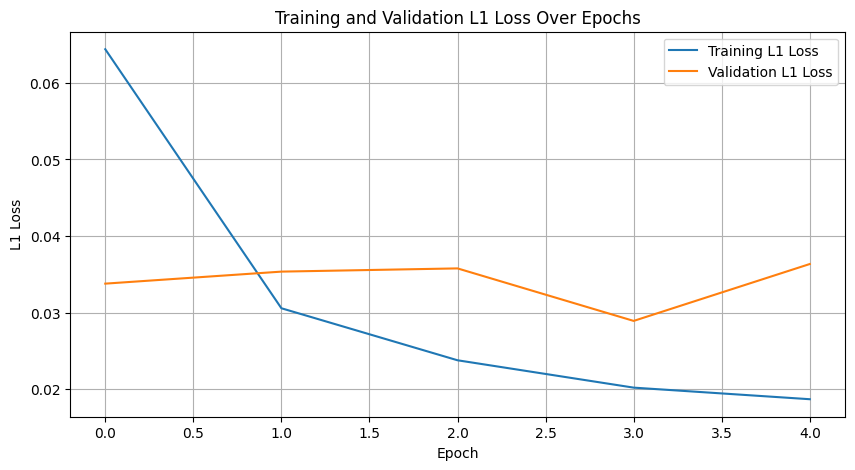

<Figure size 640x480 with 0 Axes>

In [9]:
# Plotting the L1 training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_l1_losses, label='Training L1 Loss')
plt.plot(val_l1_losses, label='Validation L1 Loss')
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Training and Validation L1 Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.savefig('training_L1_loss_plot.png')

In [11]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

model.eval()

GCNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Interpolate()
  (conv0_0): GCVGGBlock(
    (model): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (conv1_0): GCVGGBlock(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, e

In [12]:
image_path = "../SD1/val/001.png"
image = Image.open(image_path)

width, height = image.size        
truth_image = image.crop((0, 0, width // 3, height))
glare_image = image.crop((width // 3, 0, (width//3)*2, height))

truth_image_tensor = transform(truth_image)
glare_image_tensor = transform(glare_image)

truth_image_tensor = truth_image_tensor.expand(3, -1, -1)
glare_image_tensor = glare_image_tensor.expand(3, -1, -1)

truth_image_tensor = truth_image_tensor.unsqueeze(0).to(device)
glare_image_tensor = glare_image_tensor.unsqueeze(0).to(device)

In [13]:
with torch.no_grad():
    output = model(glare_image_tensor)

    # compute L1 loss
    loss = torch.nn.L1Loss()
    l1_loss = loss(output, truth_image_tensor)
    print(f"L1 Loss: {l1_loss.item()}")

# convert the output tensort to numpy
output = output.squeeze(0).cpu().numpy()
output = output.transpose(1, 2, 0)
output_image = transforms.ToPILImage()(output)

L1 Loss: 0.03300521895289421


Text(0.5, 1.0, 'Output Image')

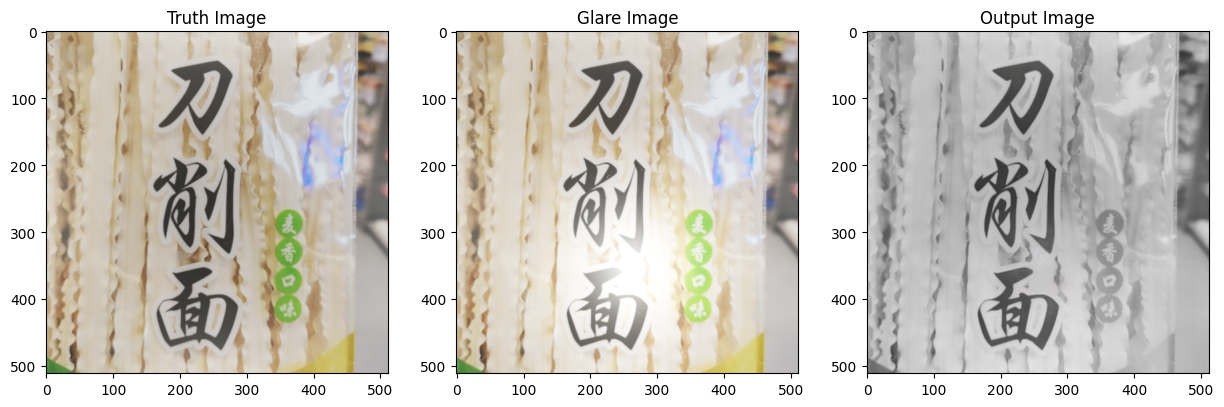

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(truth_image, cmap="gray")
ax[0].set_title("Truth Image")

ax[1].imshow(glare_image, cmap="gray")
ax[1].set_title("Glare Image")

ax[2].imshow(output_image, cmap="gray")
ax[2].set_title("Output Image")
